# Intialization

## Import

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

import keras
from keras.datasets import fashion_mnist
from keras.layers import Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout, Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import Model
from keras import metrics,Input
from keras import backend as K

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

1.15.2


Using TensorFlow backend.


In [3]:
"""
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive/', force_remount=True)\n"

## Variational Autoencoder Parameters

In [4]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)

batch_size = 100
latent_dim = 128
intermediate_dim = 512
epsilon_std = 1.0
epochs = 50
activation = 'relu'
dropout = 0.5
learning_rate = 0.001
decay = 0.0

## Load Fashion MNIST dataset

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) / 255.
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


# VAE Realization and Training

## Encoder Network
The encoder, q(z|x), is constructed by 3 conv layers and 2 fully connected layers with batch normalization, dropout and ReLU activation.
The latent output "z", a.k.a the "bottleneck" is the mean and log(var) of the distribution q.

In [6]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [7]:
enc_filters=64
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
]

In [8]:
x = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x) # private variables

_z_mean_1 = Dense(latent_dim)(_enc_dense)
_z_log_var_1 = Dense(latent_dim)(_enc_dense)

z_mean = _z_mean_1
z_log_var = _z_log_var_1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
_enc_dense = inst_layers(enc_layers, x) # private variables

_z_mean_1 = Dense(latent_dim)(_enc_dense)
_z_log_var_1 = Dense(latent_dim)(_enc_dense)

z_mean = _z_mean_1
z_log_var = _z_log_var_1

## Reparameterization Trick
This is done in order to implement BP to train the VAE end-to-end.
Since the encoder distribution q(z|x) is a Gaussian RV, it can be represented as a linear trasformation of a standard RV epslion - epsN(0,1) ; z = mu_z + std_z * eps -> zN(mu_z, var_z)

This is wrapped in a Lambda layer to be added to the model.

In [10]:
def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.sqrt(K.exp(z_log_var)) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

## Decoder Network
The decoder, p(x|z), is constructed by a FC layer, followed by 4 transposed conv layers. The first 3 with ReLU activation the last with sigmoid for the output.

In [11]:
def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

In [12]:
dec_filters = 64
decoder_layers = [
    create_dense_layers(stage=10, width=14 * 14 * 64),
    Reshape((14, 14, 64)),
    create_dec_trans_conv_layers(11, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=1, kernel_size=1, strides=1, activation='sigmoid'),
]

In [13]:
_dec_out = inst_layers(decoder_layers, z)
_output = _dec_out

## Loss Function
The variational lower bond as described in Kingma and Welling 2014, Auto-Encoding Variational Bayes.

In [14]:
def kl_loss(x, x_decoded_mean):
  # KL divergence approximation in Gaussian case
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
  # Reconstruction Loss - binary_crossentropy compares whether the pixel in the decoded image is the same as the original image
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

## Compile Model

In [15]:
vae = Model(inputs=x, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss, metrics = [logx_loss, kl_loss])
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (100, 28, 28, 1)     0                                            
__________________________________________________________________________________________________
enc_conv_1 (Conv2D)             (100, 28, 28, 64)    640         input_1[0][0]                    
__________________________________________________________________________________________________
enc_bn_1 (BatchNormalization)   (100, 28, 28, 64)    256         enc_conv_1[1][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (100, 28, 28, 64)    0           enc_bn_1[1][0]                   
____________________________________________________________________________________________

## VAE Training
Training the VAE end to end.
The network gets the same data for both  the training and validation sets.

The encoder creates a latent vector z from the input image and the decoder should reconstruct the same image.


In [16]:
start = time.time()

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
60000/60000 [==============================] - 29s 477us/step - loss: 302.9089 - logx_loss: 270.8307 - kl_loss: 32.0781
Epoch 2/50
60000/60000 [==============================] - 21s 345us/step - loss: 265.8760 - logx_loss: 247.9470 - kl_loss: 17.9291
Epoch 3/50
60000/60000 [==============================] - 21s 350us/step - loss: 258.7688 - logx_loss: 242.5441 - kl_loss: 16.2248
Epoch 4/50
60000/60000 [==============================] - 21s 352us/step - loss: 255.5888 - logx_loss: 239.9059 - kl_loss: 15.6829
Epoch 5/50
60000/60000 [==============================] - 21s 350us/step - loss: 253.7773 - logx_loss: 238.1821 - kl_loss: 15.5953
Epoch 6/50
60000/60000 [==============================] - 21s 349us/step - loss: 252.5426 - logx_loss: 236.9889 - kl_loss: 15.5536
Epoch 7/50
60000/60000 [==============================] - 21s 350us/step - loss: 251.5021 - logx_loss: 235.9501 - kl_lo

### VAE Training Results
Presented are the loss graph and the loss decrease over the precentage of training epochs.

,loss,logx_loss,kl_loss
count,50.000000,50.000000,50.000000
mean,248.566526,232.503544,16.062985
std,8.837419,6.748738,2.334453
min,244.188022,228.439590,15.551958
0%,244.188022,228.439590,15.551958
25%,244.934477,229.243523,15.661639
50%,246.083876,230.400940,15.684821
75%,248.524288,232.848969,15.717763
95%,257.337832,241.356921,16.021648
99%,284.762759,259.617684,25.145085


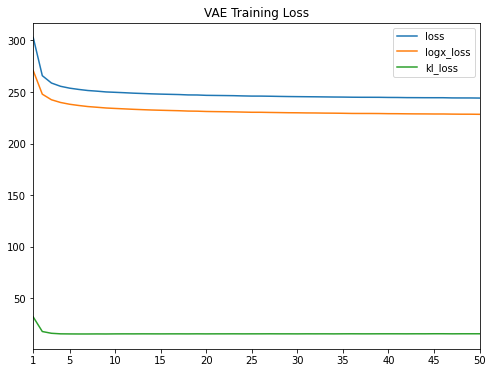

In [17]:
df = pd.DataFrame(data = history.history)
df.index += 1
ticks = list(range(0,epochs+1,5))
ticks[0] += 1;
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(xticks=ticks, xlim=(1,epochs), figsize=(8, 6), title='VAE Training Loss')

## Trained Encoder Network
The z_mean variable is now trained after the model has been fitted.
The variable is mutable and connected to the private _z_mean variable which construct the encoder network.
The mean is the output without the variance since the SVM classifier only need to clasify the mean value in order to predic the label.

In [18]:
encoder = Model(x, z_mean)

## Trained Generator Network
The decoder_layer are now trained a generator model can be constructed.

Given a latent variable z, the generator will create an image simmiliar to the ones in the Fashion MNIST dataset.

In [19]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

# Save Encoder and Generator

In [20]:
try:
    shutil.rmtree('saved_models')
except:
    pass
os.mkdir('saved_models')
encoder.save("saved_models/encoder.hdf5")
generator.save("saved_models/generator.hdf5")

# SVM Classifier Training

Create a decoded test set out of the trained encoder, where the test data set is of the form of the latent variable.

Fit an SVM classifier to predict the decoded images label as if it was original for a small amount of samples from the Fashion MNIST dataset.

Test fittness results for different amounts of samples.

The SVM classifier kernel has chosen to be the default radial basis function because of its Euclidean distance like behavior.

The training set is shuffled and splitted into an equal amount of lables from each class. A fixed seed value of 0 was chosen.

In [21]:
batch_size = 100
results = []
for sample_size in [100, 600, 1000, 3000]:
    start = time.time()
    print('Fitting with sample_size: {}'.format(sample_size))
    svm = SVC(kernel='rbf', gamma = 'auto')
    	
    if sample_size < len(X_train):
        sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train), random_state=0)
        _, index = sss.split(X_train, y_train)
        X, y = X_train[index[1]], y_train[index[1]]
    else:
        X, y = X_train, y_train
    
    X_latent = encoder.predict(X, batch_size=batch_size)
    svm.fit(X_latent, y.ravel())
    
    X_test_latent = encoder.predict(X_test, batch_size=batch_size)
    y_pred = svm.predict(X_test_latent)
    score = accuracy_score(y_test, y_pred)
    
    end = time.time()
    elapsed = end - start
    print(' * Accuracy: %.1f %%' % (100. * score))
    print(' * Fit time elapsed: %.1fs' % elapsed)
    results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})
    pickle.dump(svm, open('saved_models/svm' + '_' + str(sample_size) + '.hdf5', 'wb'))

Fitting with sample_size: 100
 * Accuracy: 63.1 %
 * Fit time elapsed: 0.9s
Fitting with sample_size: 600
 * Accuracy: 76.5 %
 * Fit time elapsed: 1.7s
Fitting with sample_size: 1000
 * Accuracy: 78.7 %
 * Fit time elapsed: 2.4s
Fitting with sample_size: 3000
 * Accuracy: 80.7 %
 * Fit time elapsed: 5.7s


### SVM Classifier Training Results

In [22]:
df = pd.DataFrame(results)
display(df)
df.to_csv('vae_m1_fashion_mnist_results.csv', index=False)

,sample_size,accuracy,time
0,100,0.6312,0.944009
1,600,0.7648,1.746563
2,1000,0.7868,2.447046
3,3000,0.8074,5.654754
